## Task 04.b.: Train a Random Forests model to identify pedestrians
### Use PCA as feature vectors
---------------------------------------------------------------------------------------------
Author: Rajesh Siraskar
Created: 16-Dec-2018
- 16-Dec-2018: First version
- 17-Dec-2018: Create flattened version of lists
- 18-Dec-2018: Add Random forests model
- 19-Dec-2018: Add evaluation using: precision, recall and F1 scores 
- 20-Dec-2018: Correct code for precsion-recall plots
- 29-Dec-2018: Create feature vectors using PCA components
- 09-Jan-2019: Remove initial data pre-paration code, use pre-processed data and simply to training and evaluation

**Objective:**
- Train an sklearn RF on **feature vectors** generated using the HOG function

**Instructions:**
- Use a balanced 70/30 train/test split
- Read the files appearing in the output train/test lists and store them as image matrices
- Process these with your HOG descriptor function before passing the resulting vectors to the classifier
- Use the Sklearn default parameters for the sklearn class for this task
- Report on performance on the 30% split
- Repeat this with different random splits and report the mean accuracy on the 30% ‘test’ sets

**Experiments:**
- Each image contains [HxW] pixels
- Simple approach: Use each *pixel value* as a feature
- Next: Pre-process image to extract more meaningful features
- Example: PCA
- For assignment: Pre-process using HoG

In [1]:
reset -f

In [2]:
## Imports

# Plot images inline with document
%matplotlib inline

# Import standard modules
import cv2            # OpenCV 
import numpy as np    # N dimensional array handling
import random         # random shuffling
import glob           # file handling
import seaborn as sns # graphics 
from matplotlib import pyplot as plt    # displaying images and plots
from sklearn.externals import joblib    # object serialization
from sklearn import metrics             # classification metrics
from sklearn.model_selection import cross_val_predict # CV

from sklearn.ensemble import RandomForestClassifier # Random forest classifier
from sklearn.decomposition import PCA               # PCA for feature vectors

# Import custom functions
from SplitInstancesIntoTrainingAndTestSets import SplitInstancesIntoTrainingAndTestSets

In [3]:
## Path variables
path_serialised_objects = 'serialised_model_data/'

### Load serialized training and test data sets

In [4]:
# Load image data and labels
train_images = joblib.load(path_serialised_objects + 'train_images.pkl')
train_labels = joblib.load(path_serialised_objects + 'train_labels.pkl')
X_train = joblib.load(path_serialised_objects + 'X_train.pkl')
y_train = joblib.load(path_serialised_objects + 'y_train.pkl')

test_images = joblib.load(path_serialised_objects + 'test_images.pkl')
test_labels = joblib.load(path_serialised_objects + 'test_labels.pkl')
X_test = joblib.load(path_serialised_objects + 'X_test.pkl')
y_test = joblib.load(path_serialised_objects + 'y_test.pkl')

print('\n Training and test data un-serialized. Read for re-use')


 Training and test data un-serialized. Read for re-use


### Show random sample of images to test import  

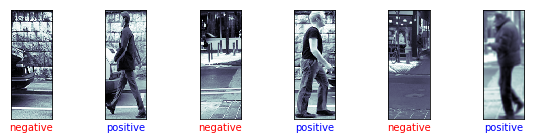

In [5]:
# Show few images to test import  
fig, axes = plt.subplots(1, 6, figsize=(10, 2), gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    index = random.sample(range(len(train_images)-1),1)[0]
    sample_image = train_images[index]
    class_label = train_labels[index]
    ax.imshow(sample_image, cmap='bone')
    ax.set(xticks=[], yticks=[], xlabel=class_label)
    if (class_label == 'positive'): ax.xaxis.label.set_color('blue')
    if (class_label == 'negative'): ax.xaxis.label.set_color('red')

### PCA for creating feature vectors

In [6]:
pca_transformer = PCA(n_components=200, svd_solver='randomized')
pca_transformer.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

### 'Mean' pedestrians

(Not in the _demeaning_ sense but in the _average_ sense)

Ref: https://www.scipy-lectures.org/packages/scikit-learn/auto_examples/plot_eigenfaces.html        

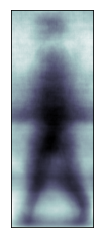

In [7]:
plt.imshow(pca_transformer.mean_.reshape(train_images[0].shape), cmap='bone')
plt.xticks([]), plt.yticks([]) # hide axis ticks
plt.show()

### eigen-pedestrians

The principal components measure deviations about the 'mean-pedestrian' shown above - along orthogonal axes (i.e. perpendicular axes, which are maximum variation axes)

The PCA components **eigen-pedestrians** are ordered by their importance.

They start from top-left showing that the first components seem to primarily take care of legs. Followed next by the torso (or torso with the side arms fused). The fourth seems to be picking up an almost 3-D image by contrasting it against the background.


thighs lighting conditions, followed by dark bodies then ghost-like white bodies, followed by legs and then probably trying to pick up arms

**One interesting observation:**

Observed closely it shows that the feet seem to be point inward.

Observation of the data-sets show that almost all pedestrian images were people walking side ways and almost none walking toward or away from the camera. To augment data an equal number of reflections were created, this meant that the feet and toes pointed left and right almost equally. PCA appears to have picked this 'cue'.

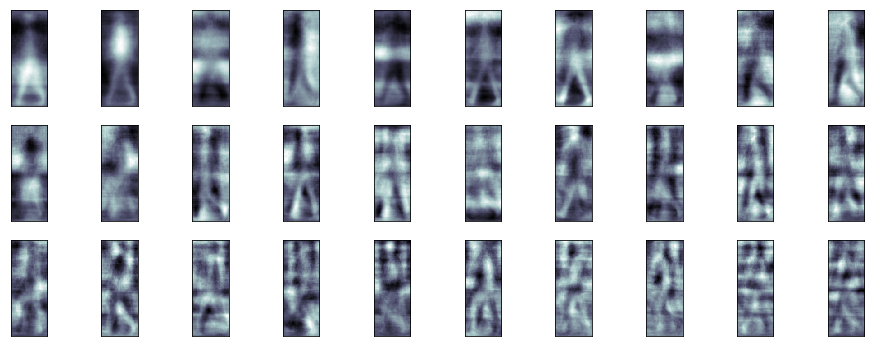

In [8]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca_transformer.components_[i].reshape(train_images[0].shape),
              cmap=plt.cm.bone)

### Transform training and test data

Having computed the PCA projects the original training and test data need to be projected onto the principal component axes to create the compressed version of most important features

In [31]:
X_train_pca = pca_transformer.transform(X_train)
X_test_pca = pca_transformer.transform(X_test)

print(X_train_pca.shape)
print(X_test_pca.shape)

(3319, 200)
(1423, 200)


### Create a random forests classifier and train it

Use the PCA components for training 

In [32]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_pca, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [33]:
y_predicted = rf_classifier.predict(X_test_pca)
y_scores = rf_classifier.predict_proba(X_test_pca)[:, 1]

**Results**
1. Precision, Recall and F1-scores
2. Confusion matrix

             precision    recall  f1-score   support

          0       0.95      0.97      0.96       716
          1       0.97      0.95      0.96       707

avg / total       0.96      0.96      0.96      1423



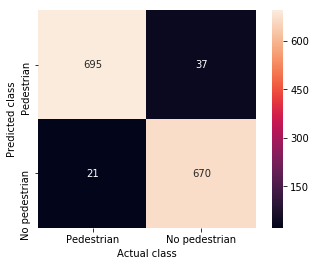

In [34]:
print(metrics.classification_report(y_test, y_predicted))

mat = metrics.confusion_matrix(y_test, y_predicted)

# Show heat-map with totals in integer format
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=['Pedestrian','No pedestrian'], yticklabels=['Pedestrian','No pedestrian'])
plt.xlabel('Actual class')
plt.ylabel('Predicted class');

In [35]:
precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_scores)
average_precision = metrics.average_precision_score(y_test, y_scores)
AUC_score = metrics.roc_auc_score(y_test, y_scores)

print('Average precision-recall score: {0:0.3f}'.format(average_precision))
print('Area under the ROC curve:       {0:0.3f}'.format(AUC_score))

Average precision-recall score: 0.989
Area under the ROC curve:       0.989


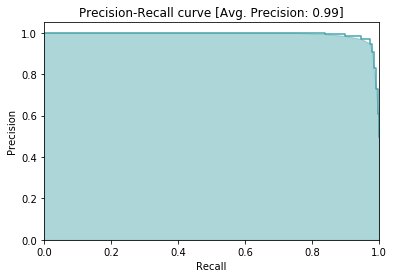

In [36]:
plt.step(recalls, precisions, color='#49a4aa')
plt.fill_between(recalls, precisions, alpha=0.45, color='#49a4aa')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.00])
plt.title('Precision-Recall curve [Avg. Precision: {0:0.2f}]'.format(average_precision))

plt.show()

In [37]:
# Pastel colors: 
# Blue #002BA1 Sea-green: #49a4aa. Dark red: #c90000. Light-purple-red 

# Ref.: Aurelien Geron Hands-on Machine Learning with Scikit Learn and TensorFlow pg:89
def plot_precision_recall_vs_threshold (precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], linestyle = 'solid', color='#49a4aa', label='Precision')
    plt.plot(thresholds, recalls[:-1], linestyle = 'solid', color='#b86b77', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='lower left')
    plt.ylim([0,1])

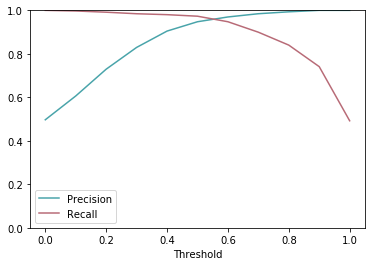

In [38]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

### Serialise and save models for testing

In [39]:
# Save the model for reuse later

joblib.dump(rf_classifier, 'serialised_model_data/rf_model_PCA.pkl')
joblib.dump(pca_transformer, 'serialised_model_data/pca_transformer.pkl')

['serialised_model_data/pca_transformer.pkl']